В данном задании вам нужно будет провести анализ данных проведенного A/B-теста.

Данные будут предоставлены в формате csv.gz. Они будут содержать также часть пред экспериментального этапа.

Описание эксперимента:
Есть мобильное приложение. В этом приложении у пользователей есть возможность покупать игровые предметы за реальные деньги. Чтобы стимулировать пользователей их покупать, приложение периодически предлагает пользователям товары - появляется окошко с рекомендацией купить товар. Отдел машинного обучения предложил улучшение для текущего алгоритма выбора рекомендации. Для проверки улучшений алгоритма был проведен A/B тест. Лог его проведения предоставлен в прикрепленном файле. 

Метрика: средний доход от пользователя за 1 неделю после первого показа ему рекомендации на 10% (после начала A/B теста время первого показа ищется снова)

Важная информация:
Эксперимент начинается 2023-05-01. Данные есть до 2023-06-01 (но можно завершить раньше, если это позволит оценка длительности)
Вам сказали, что его длительность должна составить 1 месяц.
Все покупки, которые вызваны не влиянием рекомендаций, в этом логе не учитываются

Описание данных:
id_product -  идентификатор продукта, который был рекомендован
is_pay - купил ли пользователь товар
sum_payment - размер платежа (0, если не купил)
city - город, в котором находится пользователь
id_user - пользователь
timestamp - timestamp события
date - дата события
group - группа пользователей (None, если данные не из АБ-теста)

Задачи, которые необходимо решить:
Оценить длительность теста на момент его начала. Сравнить с предложенной. Для оценки необходимо использовать данные с пред экспериментального периода. Посмотреть, есть ли выбросы в данных.
Построить методику расчета целевой метрики. Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. Посмотреть, есть ли выбросы в данных.
Рассчитать метрики из п2 по дням и построить их графики.
Принять решение о результате теста - обосновать.

Дополнительно:
При подсчете метрик обработать выбросы в данных - описать почему их можно удалить из теста, если они удаляются. Пожалуйста, не заглядывайте в будущее по данным, если рассчитанная длительность меньше предоставленных данных.

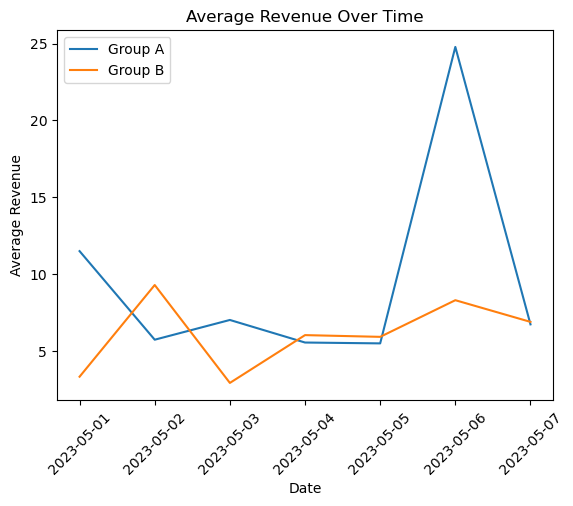

Decision: Reject the new algorithm, Effect: -0.39, P-value: 0.222


In [13]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

data = pd.read_csv('ab_hse_4.csv', parse_dates=['timestamp', 'date'])

data['date'] = pd.to_datetime(data['date'])
data = data[data['group'].notnull()] 

# Оценка длительности теста и поиск выбросов до его начала
start_experiment = pd.to_datetime('2023-05-01')
end_experiment = pd.to_datetime('2023-06-01')
pre_experiment_data = data[data['date'] < start_experiment]

# Поиск выбросов
q_low = pre_experiment_data['sum_payment'].quantile(0.01)
q_high = pre_experiment_data['sum_payment'].quantile(0.99)
pre_experiment_data_filtered = pre_experiment_data[(pre_experiment_data['sum_payment'] >= q_low) & 
                                                   (pre_experiment_data['sum_payment'] <= q_high)]

# Определение периода для расчета метрики
one_week_after_start = start_experiment + pd.Timedelta(days=7)
experiment_data = data[(data['date'] >= start_experiment) & (data['date'] < one_week_after_start)]

# Расчет среднего дохода от пользователя за первую неделю
average_revenue_A = experiment_data[experiment_data['group'] == 'A']['sum_payment'].mean()
average_revenue_B = experiment_data[experiment_data['group'] == 'B']['sum_payment'].mean()

# Расчет эффекта и p-value
effect = (average_revenue_B - average_revenue_A) / average_revenue_A
group_A_payments = experiment_data[experiment_data['group'] == 'A']['sum_payment']
group_B_payments = experiment_data[experiment_data['group'] == 'B']['sum_payment']
t_stat, p_value = stats.ttest_ind(group_A_payments, group_B_payments)

plt.plot(group_A_payments.groupby(experiment_data['date']).mean(), label='Group A')
plt.plot(group_B_payments.groupby(experiment_data['date']).mean(), label='Group B')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)
plt.title('Average Revenue Over Time')
plt.show()

# Принятие решения о результате теста
decision = "Accept the new algorithm" if p_value < 0.05 and effect > 0.1 else "Reject the new algorithm"
print(f"Decision: {decision}, Effect: {effect:.2f}, P-value: {p_value:.3f}")